# Wordle
Attempting to determine the optimal starting word for the popular online game.

https://www.nytimes.com/games/wordle/index.html

In [1]:
import pandas as pd

## To Do

o Pull list of all accepted 5-letter words  
--- Look in wordle page source? Scrape?  
--- https://www.nytimes.com/games-assets/v2/wordle.6b88b1c8c6541b07820ab0896f6bc19be0ae34b2.js  
o Allow for easy input/lookup of a custom 5-letter word and score it  

## Get input file of solutions and load into dataframe

In [2]:
sourcefile = 'https://gist.github.com/cfreshman/a7b776506c73284511034e63af1017ee/archive/845966807347a7b857d53294525263408be967ce.zip'
# https://gist.github.com/cfreshman/a7b776506c73284511034e63af1017ee#file-wordle-nyt-answers-alphabetical-txt


In [3]:
# import zipfile
 
# zip_file = "a.zip"
 
# try:
#     with zipfile.ZipFile(zip_file) as z:
#         z.extractall()
#         print("Extracted all")
# except:
#     print("Invalid file")

In [4]:
localfile = 'wordle-nyt-answers-alphabetical.txt'

In [5]:
# load master word list
df = pd.read_csv(localfile, header=None)
# set name for the column - it's from a text file and thus has no header
df.columns = ['full_word']

df.head()

,full_word
0,aback
1,abase
2,abate
3,abbey
4,abbot


## Conduct positional frequency assessment

In [6]:
# break up words into individual letters 
looprange = range(0,5) # we know we will only have 5 columns
colnames_all = []

for i in looprange:
    colname = 'l'+str(i+1)
    colnames_all.append(colname) # keep a running list of all col names so we can iterate later
    df[colname] = df['full_word'].str[i]

df.head()

,full_word,l1,l2,l3,l4,l5
0,aback,a,b,a,c,k
1,abase,a,b,a,s,e
2,abate,a,b,a,t,e
3,abbey,a,b,b,e,y
4,abbot,a,b,b,o,t


In [7]:
# count how many times a given letter occurs in a specific position

# generate list of lower case letters
# we will use this as the index for our empty array 
alphabet = []
for letter in range(97,123):
    alphabet.append(chr(letter))

# convert list to dataframe index
df_alpha = pd.DataFrame(alphabet)
df_alpha.columns = ['letter'] 
df_cts = df_alpha.set_index('letter')
df_cts

# loop through all columns and find frequency of each letter
# store results in a the new dataframe
for i in colnames_all:
    df_value_counts = pd.DataFrame(df[i].value_counts())
    df_value_counts.columns = ['ct_l1'] # change column names
    df_cts[i] = df_value_counts
    
# clean up the output
df_cts = df_cts.fillna(0).astype(int)
df_cts

,l1,l2,l3,l4,l5
letter,,,,,
a,140,304,306,162,63
b,173,16,56,24,11
c,198,40,56,150,31
d,111,20,75,69,118
e,72,241,177,318,422
f,135,8,25,35,26
g,115,11,67,76,41
h,69,144,9,28,137
i,34,201,266,158,11


## Plot most common letters by position 

maybe pull the color map out of the loop so the colors are relative to the full df max

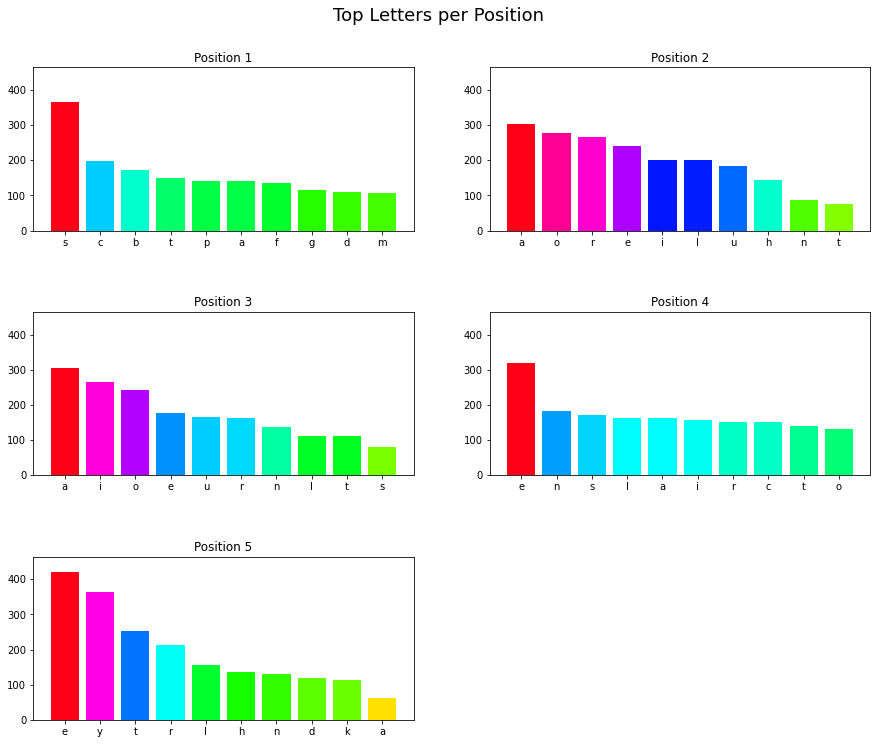

In [48]:
import matplotlib.pyplot as plt
from matplotlib import cm

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Top Letters per Position", fontsize=18, y=0.95)

# set the number of bars to plot
top_n = 10

# set up colors for bars
# col_map = plt.get_cmap('Pastel1')
col_map = plt.get_cmap('YlOrRd')

# find the overall max value for consistent scaling
y_max = df_cts.to_numpy().max()

# loop through the letter positions and keep track of index
for n, col in enumerate(colnames_all):
    # add a new subplot iteratively
    ax = plt.subplot(3, 2, n + 1)

    # filter df and plot letter frequency on the new subplot axis
    df_toplot = df_cts[col].sort_values(ascending=False).head(top_n)
    x = list(df_toplot.index.values)
    y = df_toplot
    col_map = cm.hsv(y / float(max(y)))

#     ax.bar(x, y, color=col_map.colors)
    ax.bar(x, y, color=col_map)
#     ax.bar(x, y, cmap='YlOrRd')
    
    # chart formatting
    ax.set_title("Position "+str(n+1))
    ax.set_xlabel("")
    plt.ylim(0,y_max*1.1)

## Find best starting word
"Best" meaning the word composed of the highest-frequency letters.

Assign a score based on relative positional value?  
Simply use the frequency/count as this score?

For each word in the master list  
- Score each letter based on its frequency  
--- Could replace each letter with its frequency/score
- Sum scores to new column

In [33]:
# map score (per letter•position) back to word
df_freq = df.replace(df_cts)

In [34]:
# cacluate total score per word
df_freq = df_freq.drop(['score'], axis=1, errors='ignore')
df_freq['score'] = df_freq.sum(axis = 1)
df_freq.head()

,full_word,l1,l2,l3,l4,l5,score
0,aback,140,16,306,150,113,725
1,abase,140,16,306,171,422,1055
2,abate,140,16,306,139,422,1023
3,abbey,140,16,56,318,364,894
4,abbot,140,16,56,132,253,597


In [36]:
# sort words by score
df_freq.sort_values('score',ascending=False).head(10)

,full_word,l1,l2,l3,l4,l5,score
1773,slate,365,200,306,139,422,1432
1644,sauce,365,304,165,150,422,1406
1778,slice,365,200,266,150,422,1403
1700,shale,365,144,306,162,422,1399
1647,saute,365,304,165,139,422,1395
1837,sooty,365,279,243,139,364,1390
1707,share,365,144,306,150,422,1387
1722,shine,365,144,266,182,422,1379
1958,suite,365,185,266,139,422,1377
457,crane,198,267,306,182,422,1375


In [41]:
# compare to the closest starting word to mine ("strep")
df_freq.loc[df_freq['full_word'] == 'strap']

,full_word,l1,l2,l3,l4,l5,score
1942,strap,365,77,163,162,56,823


In [71]:
import seaborn as sns
palette = sns.color_palette("Pastel1", 5).as_hex()
palette

'#b3cde3'

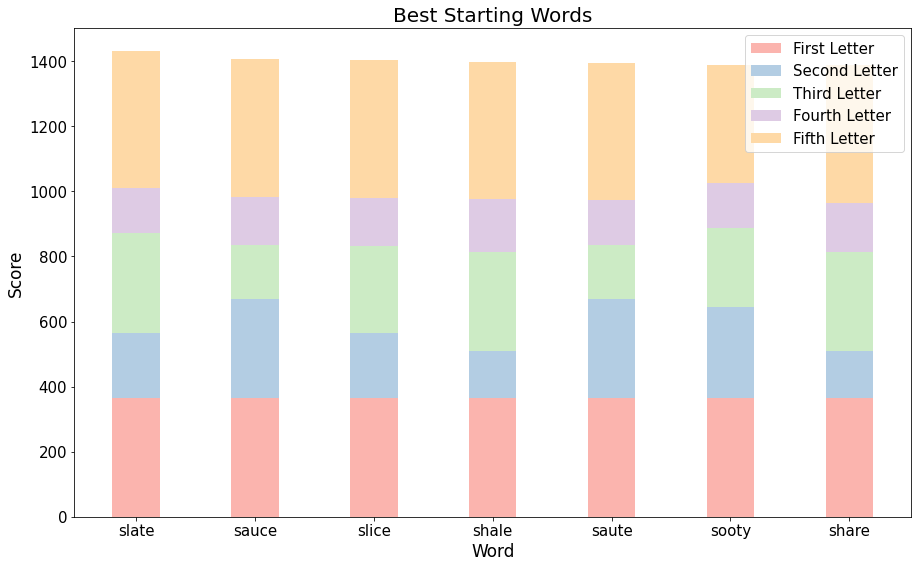

In [76]:
# plot top words and their contributions
# the plotting can probably be done more elegantly via a 'for' loop

import numpy as np

# number of words to plot
top_n_words = 7

# Visualizing the data with stacked bar chart
plt.figure(figsize=[15, 9])

# downselect data to plot
df_freq_toplot = df_freq.sort_values('score',ascending=False).head(top_n_words)

# Set the width of the bars
wd = 0.4
x_pos = np.arange(len(df_freq_toplot))

# Plotting the multiple bar graphs on top on other
plt.bar(x_pos, df_freq_toplot.l1, color=palette[0], width=wd, label='First Letter')
plt.bar(x_pos, df_freq_toplot.l2, color=palette[1], width=wd, label='Second Letter', 
       bottom=df_freq_toplot.l1)
plt.bar(x_pos, df_freq_toplot.l3, color=palette[2], width=wd, label='Third Letter', 
       bottom=df_freq_toplot.l1+df_freq_toplot.l2)
plt.bar(x_pos, df_freq_toplot.l4, color=palette[3], width=wd, label='Fourth Letter', 
       bottom=df_freq_toplot.l1+df_freq_toplot.l2+df_freq_toplot.l3)
plt.bar(x_pos, df_freq_toplot.l5, color=palette[4], width=wd, label='Fifth Letter', 
       bottom=df_freq_toplot.l1+df_freq_toplot.l2+df_freq_toplot.l3+df_freq_toplot.l4)

# Add xticks
plt.xticks(x_pos, df_freq_toplot.full_word.values, fontsize=15)
plt.yticks(fontsize=15)
plt.title('Best Starting Words', fontsize=20)
plt.xlabel('Word', fontsize=17)
plt.ylabel('Score', fontsize=17)

plt.legend(loc='upper right', fontsize=15)
plt.show()

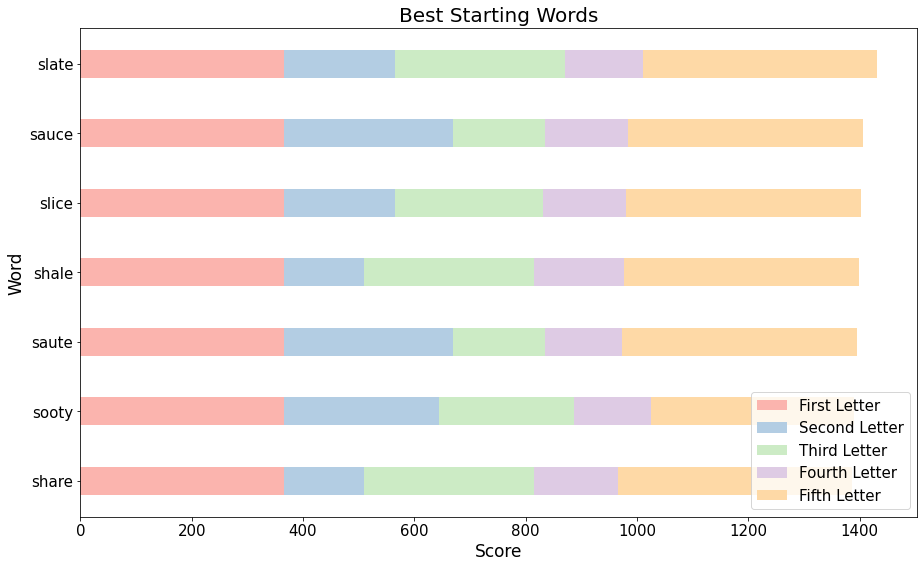

In [86]:
# ALT VERSION: horizontal stacked bar
# plot top words and their contributions
# the plotting can probably be done more elegantly via a 'for' loop

import numpy as np

# number of words to plot
top_n_words = 7

# Visualizing the data with stacked bar chart
plt.figure(figsize=[15, 9])

# downselect data to plot
df_freq_toplot = df_freq.sort_values('score',ascending=False).head(top_n_words).sort_values('score',ascending=True)

# Set the width of the bars
wd = 0.4
x_pos = np.arange(len(df_freq_toplot))

# Plotting the multiple bar graphs on top on other
plt.barh(x_pos, df_freq_toplot.l1, color=palette[0], height=wd, label='First Letter')
plt.barh(x_pos, df_freq_toplot.l2, color=palette[1], height=wd, label='Second Letter', 
       left=df_freq_toplot.l1)
plt.barh(x_pos, df_freq_toplot.l3, color=palette[2], height=wd, label='Third Letter', 
       left=df_freq_toplot.l1+df_freq_toplot.l2)
plt.barh(x_pos, df_freq_toplot.l4, color=palette[3], height=wd, label='Fourth Letter', 
       left=df_freq_toplot.l1+df_freq_toplot.l2+df_freq_toplot.l3)
plt.barh(x_pos, df_freq_toplot.l5, color=palette[4], height=wd, label='Fifth Letter', 
       left=df_freq_toplot.l1+df_freq_toplot.l2+df_freq_toplot.l3+df_freq_toplot.l4)

# Add xticks
plt.yticks(x_pos, df_freq_toplot.full_word.values, fontsize=15)
plt.xticks(fontsize=15)
plt.title('Best Starting Words', fontsize=20)
plt.ylabel('Word', fontsize=17)
plt.xlabel('Score', fontsize=17)

plt.legend(loc='lower right', fontsize=15)
plt.show()

## --- THOROUGHLY CHECK THESE LOOKUPS ---

In [13]:
df.head()

,full_word,l1,l2,l3,l4,l5
0,aback,a,b,a,c,k
1,abase,a,b,a,s,e
2,abate,a,b,a,t,e
3,abbey,a,b,b,e,y
4,abbot,a,b,b,o,t


In [14]:
df_cts.head()

,l1,l2,l3,l4,l5
letter,,,,,
a,140,304,306,162,63
b,173,16,56,24,11
c,198,40,56,150,31
d,111,20,75,69,118
e,72,241,177,318,422


In [17]:
df_freq.head()

,full_word,l1,l2,l3,l4,l5
0,aback,140,16,306,150,113
1,abase,140,16,306,171,422
2,abate,140,16,306,139,422
3,abbey,140,16,56,318,364
4,abbot,140,16,56,132,253


In [ ]:
# Plot (stacked?) bar for top solutions


## Find the score of any specified 5-letter combination

## Find the best word if you're okay with a yellow
https://wordfinder.yourdictionary.com/blog/the-worst-wordle-words-that-only-hinder-your-game/  

## Find the best word if it doesn't have to be a solution
https://towardsdatascience.com/loaded-words-in-wordle-e78cb36f1e3c  

Where to find a list of all 5-letter words that the game will accept?

## BONUS: Find best option given a known letter/position

### References
https://stackoverflow.com/questions/51896168/create-new-data-frame-with-the-name-from-loop-number

https://towardsdatascience.com/easy-grouped-bar-charts-in-python-b6161cdd563d  
https://www.pythoncharts.com/matplotlib/grouped-bar-charts-matplotlib/  
https://pythonguides.com/matplotlib-plot-bar-chart/  
https://engineeringfordatascience.com/posts/matplotlib_subplots/

https://matplotlib.org/stable/gallery/color/colormap_reference.html  
https://stackoverflow.com/questions/31313606/pyplot-matplotlib-bar-chart-with-fill-color-depending-on-value  
https://holypython.com/python-visualization-tutorial/colors-with-python/

https://stackoverflow.com/questions/53118854/replace-values-in-dataframe-using-a-lookup-dataframe

### Scrapyard

In [ ]:
# df_c1 = df.value_counts('l1').rename_axis('letter').reset_index(name='ct_l1')
# df_c1

In [ ]:
# # df.value_counts('l1').to_frame()

# value_counts = df['l1'].value_counts()

# # converting to df and assigning new names to the columns
# df_value_counts = pd.DataFrame(value_counts)
# # df_value_counts = df_value_counts.reset_index()
# df_value_counts.columns = ['ct_l1'] # change column names
# df_value_counts

In [ ]:

# # converting to df and assigning new names to the columns
# df_value_counts = pd.DataFrame(df['l1'].value_counts())
# df_value_counts.columns = ['ct_l1'] # change column names
# df_value_counts

In [ ]:
# df_ct_all = pd.merge(df_c1, df_c2, on = 'letter', how = 'outer')

# # need to clean up NaNs (replace with 0)
# # convert all to integer

# df_ct_all

In [ ]:
import matplotlib.pyplot as plt

df_toplot = df_cts['l1'].sort_values(ascending=False).head()

# my_cmap = plt.get_cmap("viridis")
# col_map = plt.get_cmap('tab20c')
col_map = plt.get_cmap('Pastel1')
my_colors = ['r', 'y', 'g', 'b', 'c']

# x = df_toplot['letter']
x = list(df_toplot.index.values)
y = df_toplot
plt.bar(x, y, color=col_map.colors)

plt.xlabel('Letter')
plt.ylabel('Count')
plt.title('Top Letters for Position 1')

plt.show()

In [ ]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Top Letters per Position", fontsize=18, y=0.95)

# my_cmap = plt.get_cmap("viridis")
# col_map = plt.get_cmap('tab20c')
col_map = plt.get_cmap('Pastel1')
my_colors = ['r', 'y', 'g', 'b', 'c']

# loop through the length of tickers and keep track of index
for n, col in enumerate(colnames_all):
    # add a new subplot iteratively
    ax = plt.subplot(3, 2, n + 1)

    # filter df and plot ticker on the new subplot axis
#     df[df["colname"] == col].plot(ax=ax)
    df_toplot = df_cts[col].sort_values(ascending=False).head()
    x = list(df_toplot.index.values)
    y = df_toplot
    ax.bar(x, y, color=col_map.colors)


    # chart formatting
#     ax.set_title(col.upper())
    ax.set_title("Position "+str(n+1))
#     ax.get_legend().remove()
    ax.set_xlabel("")